# A Tutorial on Deep Learning-based (Profiled) Side-channel Analysis (DLSCA)

This notebook contains executable code that complements the article "A Tutorial on Deep Learning-based (Profiled) Side-channel Analysis (DLSCA)". It provides concrete implementations of the deep learning-based side-channel analysis techniques described in the paper, allowing readers to reproduce experiments, explore different configurations, and gain a deeper understanding of the subject matter through hands-on experience.

Code cells should be executed sequentially in the order they are shown within each section so that appropriate variables and functions are defined and implemented for common later use in the following code cell if not used immediately in the same one. Some sections are standalone, meaning they can be executed right after running the section Imports and Setup, while some rely on other sections as well. This is noted for each section.



## Imports and Setup

The following code cell imports all required libraries. These are typically pre-installed in the Google Colab environment. If any are missing, they can be installed using the following command:
```
!pip install <name_of_the_package>
```

This code cell also implements other required functions and variables assumed in the later code cells. So, this cell should be executed before running any other code cell(s).


In [1]:
# importing necessary libraries
import os
# import tensorflow as tf
# import tensorflow.keras as tk
# from tensorflow.keras.models import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras import layers
# from tensorflow.keras.layers import *
# from tensorflow.keras.utils import to_categorical
# from tensorflow.python.keras import backend as K

import sys
import h5py
import numpy as np
import random
import math
import gc
import importlib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt

# set a random seed for reproducibility (running with the given numbers should lead to the same results)
seed = 1502117258716530292 #random.randrange(sys.maxsize)
random.seed(seed)
# print('seed random was', seed)
seed = 4188638569 #random.randrange(2**32 - 1)
np.random.seed(seed)
# print('seed np random was', seed)

# The dataset implements AES-128, for which a known and fixed AES substitution table exists.
# This S-box is used for the attack, so we define it here as a prerequisite for running later code.
AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

# This function checks if the file exists and will be used to read the dataset files.
def check_file_exists(file_path):
    if os.path.exists(file_path) == False:
        print("Error: provided file path '%s' does not exist!" % file_path)
        sys.exit(-1)
    return

# Function to load profiling and attack data (traces and labels) (source : https://github.com/ANSSI-FR/ASCAD)
def load_ascad(ascad_database_file, load_metadata=False, target_byte=2):
	check_file_exists(ascad_database_file)
	# Open the ASCAD database HDF5 for reading
	try:
		in_file	 = h5py.File(ascad_database_file, "r")
	except:
		print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
		sys.exit(-1)
	# Load profiling traces
	X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
	# Load profiling labels
	Y_profiling = np.array(in_file['Profiling_traces/labels'])
	# Load attacking traces
	X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
	# Load attacking labels
	Y_attack = np.array(in_file['Attack_traces/labels'])
	if load_metadata == False:
		return (X_profiling, Y_profiling), (X_attack, Y_attack)
	else:
		return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])

# ID means the label values are taken directly
# For HW leakage model, we show how the conversion is done
def calculate_HW(data):
    hw = [bin(x).count("1") for x in range(256)]
    return [hw[int(s)] for s in data]

# Functions for returning GE vector for increasing number of traces
def score_keys_convergence(predictions, plaintexts):
  """
  Computes the scores for each key hypothesis
  """
  scores_keys = np.zeros((256, predictions.shape[0]))
  for k in range(256):
    # Generate Hypothetical labels for a key-candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    for i in range(predictions.shape[0]):
      scores_keys[k, i] = scores_keys[k,i-1] + predictions[i, hypothetical_labels[i]]
  return scores_keys

def guessing_entropy_convergence(predictions, plaintexts, correct_key, nb_traces, nb_attacks=100):
  ranks = np.zeros((nb_attacks, nb_traces))
  # Take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):
    # Take random subset of traces
    r = np.random.choice(
            range(predictions_log.shape[0]), nb_traces, replace=False)

    key_scores = score_keys_convergence(predictions_log[r], plaintexts[r])

    for n in range(nb_traces):
      order_keys = np.argsort(key_scores[:, n])[::-1]
      ranks[attack, n]  = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks, axis=0), np.average(ranks, axis=0)

# Functions to calculate GE for a given number of attack traces
def score_keys(predictions, plaintexts):
  """
  Computes the scores for each key hypothesis
  """
  scores_keys = np.zeros(256)
  for k in range(256):
    #Generate Hypothetical labels for a key-candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    for i in range(predictions.shape[0]):
      scores_keys[k] += predictions[i, hypothetical_labels[i]]
  return scores_keys

def guessing_entropy(predictions, plaintexts, correct_key, nb_traces, nb_attacks=100):
  ranks = np.zeros(nb_attacks)
  # Take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):
    # Take random subset of traces
    r = np.random.choice(
            range(predictions_log.shape[0]), nb_traces, replace=False)

    key_scores = score_keys(predictions_log[r], plaintexts[r])

    order_keys = np.argsort(key_scores)[::-1]

    ranks[attack] = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks), np.average(ranks)

## Downloading the Dataset

We download the public dataset, ASCAD with variable key, using the following code and the link provided. This downloads the data in the temporary disk of the Colab and will be deleted after the session ends.


In [9]:
# download the data
!wget https://static.data.gouv.fr/resources/ascad-atmega-8515-variable-key/20190903-083349/ascad-variable.h5

--2025-09-19 13:44:18--  https://static.data.gouv.fr/resources/ascad-atmega-8515-variable-key/20190903-083349/ascad-variable.h5
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.73, 37.59.183.91
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438606904 (418M) [application/octet-stream]
Saving to: ‘ascad-variable.h5.1’

ascad-variable.h5.1  34%[=====>              ] 143.04M  7.25MB/s    eta 38s    ^C


To avoid downloading the dataset for each session, we can mount My Drive from Google Account, which allows us to use data already in the My Drive. Thus, the public dataset can be within your My Drive, and the path to the dataset has to be updated in the tutorial. However, this tutorial will rely on the downloaded dataset within the temporary disk for the controlled execution process.

The code for mounting the Drive is the following:

```
from google.colab import drive
drive.mount('/content/drive')
```


The following code cell of the tutorial does not have to be executed for the attack to run but is informative for understanding how the labels are created.

In [2]:
## This part of the tutorial does not have to be executed for the attack to run
## This is informative for understanding how the labels are created
ascad_dataset = './content/ascad-variable.h5'
target_byte = 2 # we attack the third key byte (which is 2 in 0-index array)
(X_profiling, Y_profiling), (X_attack, Y_attack), (profiling_metadata, attack_metadata) = load_ascad(ascad_dataset, load_metadata=True, target_byte=target_byte)

# Load the plaintexts of the profiling traces of the corresponding target byte
profiling_plaintexts = profiling_metadata['plaintext'][:, target_byte].astype(np.uint8)
# Load the target_byte value of the key of the corresponding profiling traces
profiling_keys =  profiling_metadata['key'][:, target_byte].astype(np.uint8)
# Calculate the correct label using the plaintext and key byte of the profiling set
created_Y_profiling = AES_Sbox[profiling_plaintexts ^ profiling_keys]
assert (created_Y_profiling == Y_profiling).all(), "Calculated profiling labels are not equal to loaded labels."

# Similar process for attack set
attack_plaintexts = attack_metadata['plaintext'][:, target_byte].astype(np.uint8)
attack_keys =  attack_metadata['key'][:, target_byte].astype(np.uint8)
created_Y_attack = AES_Sbox[attack_plaintexts ^ attack_keys]
assert (created_Y_attack == Y_attack).all(), "Calculated attack labels are not equal to loaded labels."

The following code cell loads the dataset downloaded in the temporary disk. This path has to be updated when data stored in the My Drive (mounting the Drive) is used.

In [9]:
ascad_dataset = './content/ascad-variable.h5'
(X_profiling, Y_profiling), (X_attack, Y_attack), (profiling_metadata, attack_metadata) = load_ascad(ascad_dataset, load_metadata=True)
input_size = len(X_profiling[0])

### Preprocessing for Deep Learning



Standardization and normalization are common for deep learning preprocessing, and the following code cell uses the scikit-learn library implementation for those calculations.

In [4]:
# Standardization
scaler = StandardScaler()
X_profiling = scaler.fit_transform(X_profiling)
X_attack = scaler.transform(X_attack)
# Normalization (between 0 and 1) - Generally this is more for desynchronized traces
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_profiling = scaler.fit_transform(X_profiling)
# X_attack = scaler.transform(X_attack)

### Leakage Model and Classification Task Label Preparation

In [5]:
# Depending on the leakage model, we have different number of classes for the classification
leakage_model = 'ID'
if leakage_model == 'HW':
  nb_classes = 9
elif leakage_model == 'ID':
  nb_classes = 256

if leakage_model == 'HW':
  Y_profiling = calculate_HW(Y_profiling)
  Y_attack = calculate_HW(Y_attack)

# Since we use classification, we turn the the label values into categorical
Y_profiling = to_categorical(Y_profiling, num_classes=nb_classes)
Y_attack = to_categorical(Y_attack, num_classes=nb_classes)

NameError: name 'to_categorical' is not defined

##Fixed Model Training
This section shows how to train a single fixed neural network architecture for DLSCA.

Both sections *Imports and Setup* and *Downloading the Dataset* must be executed before running cells in this section.

### Models
The following code cell has functions, each creating a fixed model for training (profiling), and they are taken from reported research papers.

In [ ]:
# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
def best_mlp_id_opoi_1400_ascadr(classes, number_of_samples):
    # Best multilayer perceptron for ASCAD variable key dataset
    # Number of points-of-interest: 1400
    # Leakage model: ID
    # POI interval: [80945, 82345]
    # Number of parameters: 34236

    batch_size = 100
    tf.random.set_seed(83545)
    model = Sequential(name='best_mlp_id_opoi_ascadv_1400')
    model.add(Dense(20, activation='selu', kernel_initializer='random_uniform', input_shape=(number_of_samples,)))
    model.add(Dense(20, activation='selu', kernel_initializer='random_uniform'))
    model.add(Dense(20, activation='selu', kernel_initializer='random_uniform'))
    model.add(Dense(classes, activation='softmax'))
    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model, batch_size

# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
def best_cnn_id_opoi_1400_ascadr(classes, number_of_samples):
    # Best Convolutional Neural Network for ASCAD variable key dataset
    # Number of points-of-interest: 1400
    # Leakage model: ID
    # POI interval: [80945, 82345]
    # Number of parameters: 87632

    batch_size = 300
    tf.random.set_seed(511628)
    model = Sequential(name='best_cnn_id_opoi_ascadv_1400')
    model.add(Conv1D(kernel_size=46, strides=23, filters=8, activation='selu', input_shape=(number_of_samples, 1), padding='same'))
    model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(kernel_size=50, strides=25, filters=16, activation='selu', padding='same'))
    model.add(MaxPool1D(pool_size=6, strides=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(kernel_size=44, strides=22, filters=32, activation='selu', padding='same'))
    model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(200, activation='selu', kernel_initializer='he_uniform'))
    model.add(Dense(classes, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model, batch_size

# Model taken from Benadjila, Ryad, et al.
# "Deep learning for side-channel analysis and introduction to ASCAD database."
# Journal of Cryptographic Engineering 10.2 (2020): 163-188.
def mlp_best(classes, number_of_samples):
  node=200
  layer_nb=6
  model = Sequential()
  model.add(Dense(node, input_dim=number_of_samples, activation='relu'))
  for i in range(layer_nb-2):
    model.add(Dense(node, activation='relu'))
  model.add(Dense(classes, activation='softmax'))
  optimizer = Adam(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model


### Training/Profiling
First phase of (DL)SCA.

We create the model by calling one of the functions. The training is done by calling the function *fit* on the model.

In [ ]:
# print(len(nb_classes))
# print(len(input_size))

TypeError: object of type 'int' has no len()

In [ ]:
model, batch_size = best_mlp_id_opoi_1400_ascadr(nb_classes, input_size)
nb_epochs = 100
history = model.fit(x=X_profiling, y=Y_profiling, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0039 - loss: 5.5457
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0045 - loss: 5.5447
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0048 - loss: 5.5432
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0052 - loss: 5.5410
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0056 - loss: 5.5372
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0061 - loss: 5.5272
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0071 - loss: 5.5110
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0073 - loss: 5.5012
Epoch 9/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0076 - loss: 5.4914
Epoch 10/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0094 - loss: 5.4415
Epoch 11/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0103 - loss: 5.3859
Epoch 12/100
2000/

A recommended option is to use a validation set to better evaluate and estimate the model's performance.

This can be done like this:

```
validation_split = 0.1
history = model.fit(x=X_profiling, y=Y_profiling, validation_split=validation_split, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)
```

### Executing the Attack
Second phase of (DL)SCA.

The model is trained now, and we evaluate the performance of the profiling model by using SCA evaluation metrics, such as guessing entropy or success rate. Here, we provide the implementation of the guessing entropy.

Following the definition of success rate from the tutorial paper, the GE implementation can be adapted to calculate the success rate instead.

In [ ]:
# Functions to calculate GE for a given number of attack traces
def score_keys(predictions, plaintexts):
  """
  Computes the scores for each key hypothesis
  """
  scores_keys = np.zeros(256)
  for k in range(256):
    #Generate Hypothetical labels for a key candidate k
    hypothetical_labels = AES_Sbox[plaintexts ^ k]
    if leakage_model == "HW":
      hypothetical_labels = calculate_HW(hypothetical_labels)

    for i in range(predictions.shape[0]):
      scores_keys[k] += predictions[i, hypothetical_labels[i]]
  return scores_keys

def guessing_entropy(predictions, plaintexts, correct_key, nb_traces, nb_attacks=100):
  ranks = np.zeros(nb_attacks)
  # Take log of probablities to sum later with small addition for numeric stability
  predictions_log = np.log(predictions + 1e-36)

  for attack in range(nb_attacks):
    # Take random subset of traces
    r = np.random.choice(
            range(predictions_log.shape[0]), nb_traces, replace=False)

    key_scores = score_keys(predictions_log[r], plaintexts[r])

    order_keys = np.argsort(key_scores)[::-1]

    ranks[attack] = np.where(order_keys == correct_key)[0][0]
  return np.median(ranks), np.average(ranks)

In [ ]:
# First, we make a prediction with the trained model on the traces from the attack set (not used in the training).
predictions = model.predict(X_attack)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [ ]:
target_byte = 2 # we attack the third key byte (which is 2 in 0-index array)
correct_key = attack_metadata["key"][0, target_byte] # 0 because it is fixed key so we just get the first in the array
median_ge, avg_ge = guessing_entropy(predictions, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"GE using median is {median_ge}, while using average, GE is {avg_ge}.")

GE using median is 0.0, while using average, GE is 0.0.


In [ ]:
# Use the more common calculation of GE where the convergence is included, and GE is calculated for the increasing number of traces.
# This function is defined in the Imports and Setup section.
correct_key = attack_metadata["key"][0, target_byte] # 0 because it is fixed key so we just get the first in the array
medge, avgge = guessing_entropy_convergence(predictions, attack_metadata["plaintext"][:, target_byte], correct_key, nb_traces=1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")

GE of 0.0 with 436 traces.


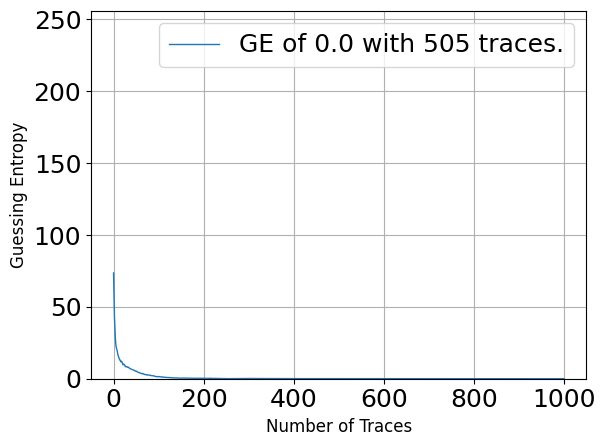

In [ ]:
# Common way to show GE convergence in related research papers.
figure = plt.gcf()
plt.rcParams.update({'font.size': 18})
plt.plot(avgge, linewidth=1, label=f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
plt.grid(True, which="both", ls="-")
plt.xlabel("Number of Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

## Data Augmentation (DA)
Here, we describe methods for implementing data augmentation techniques. We show how to add Gaussian noise and implement random shifts. The code here retrains the model from the previous section, *Fixed Model Training*, with added modifications to the original profiling data, supplemented with a data-augmentation training process.

Thus, this section expects the code from sections *Imports and Setup*, *Downloading the Dataset*, and *Fixed Model Training* (only subsection *Models*) to be executed so that all variables and functions are defined and implemented for running the following DA code.

In [ ]:
# set a random seed for reproducibility (running with the given numbers should lead to the same results)
seed = 2770010422235544677 #random.randrange(sys.maxsize)
random.seed(seed)
# print('seed random was', seed)
seed = 512451064 #random.randrange(2**32 - 1)
np.random.seed(seed)
# print('seed np random was', seed)

# Adding Gaussian noise
def data_augmentation_noise(orig_x_prof, num_repeats=2, std=0.01):
  # create copy of original
  new_x_prof = orig_x_prof.copy()
  nb_orig_traces = len(orig_x_prof)

  # repeat it n times
  new_x_prof = np.tile(new_x_prof, (num_repeats, 1))

  # add gaussian noise to added traces (original traces remain without additional noise)
  new_x_prof[nb_orig_traces:] += np.random.normal(0, std, new_x_prof[nb_orig_traces:].shape)
  return new_x_prof

# Adding random shifts
def data_augmentation_shift(orig_x_prof, num_repeats=2, max_shift=10):
  # create copy of original
  new_x_prof = orig_x_prof.copy()
  nb_orig_traces = len(orig_x_prof)

  # repeat it n times
  new_x_prof = np.tile(new_x_prof, (num_repeats, 1))

  # shift each trace randomly using np roll function
  for i in range(len(new_x_prof[nb_orig_traces:])):
    shift = random.randint(-max_shift, max_shift)
    new_x_prof[nb_orig_traces+i] = np.roll(new_x_prof[nb_orig_traces+i], shift)
  return new_x_prof

nb_epochs = 100
n_repeats = 2

# Define model
model, batch_size = best_mlp_id_opoi_1400_ascadr(nb_classes, input_size)
nb_prof_traces = 50000
X_prof = X_profiling[:nb_prof_traces]
Y_prof = Y_profiling[:nb_prof_traces]

# Repeat the data n times using tile
Y_prof = np.tile(Y_prof, (n_repeats, 1))

for i in range(nb_epochs):
  new_x = data_augmentation_shift(X_prof, num_repeats=n_repeats)
  model.fit(x=new_x, y=Y_prof, shuffle=True, batch_size=batch_size, verbose=1, epochs=1)
  gc.collect()

seed random was 2770010422235544677
seed np random was 512451064


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0037 - loss: 5.5452
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0048 - loss: 5.5414
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0052 - loss: 5.5368
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0060 - loss: 5.5322
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0064 - loss: 5.5283
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0067 - loss: 5.5239
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0074 - loss: 5.5189
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0072 - loss: 5.5132
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0084 - loss: 5.4926
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0096 - loss: 5.4416
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0104 - loss: 5.4138
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0107 - loss: 5.3962
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0119 - loss: 5.3801

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
GE of 0.17 with 987 traces.


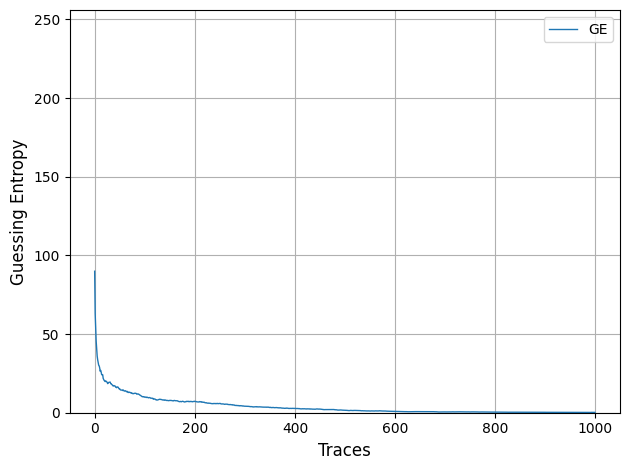

In [ ]:
# Code cell that evaluates the DA training and plots the GE convergence.
predictions = model.predict(X_attack)
target_byte = 2
correct_key = attack_metadata["key"][0, target_byte]
medge, avgge = guessing_entropy_convergence(predictions, attack_metadata["plaintext"][:, target_byte], correct_key, 1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
figure = plt.gcf()
plt.plot(avgge, linewidth=1, label="GE")
plt.grid(True, which="both", ls="-")
plt.xlabel("Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

## Explainability
In this section, we show basic visualization techniques that can indicate what points in the trace contribute to the network predictions. We further compute the Signal-to-Noise ratio for various secret shares related to the target intermediate value and match the leakage of these shares to the visualizations for the network.

Note that this code relies on the model from the above steps being trained (expects the previous sections to be executed before running cells in this section). The gradient visualization is from:

Masure, L., Dumas, C., & Prouff, E. (2019). Gradient visualization for general characterization in profiling attacks. In Constructive Side-Channel Analysis and Secure Design: 10th International Workshop, COSADE 2019, Darmstadt, Germany, April 3–5, 2019, Proceedings 10 (pp. 145-167). Springer International Publishing.

In [ ]:
# Function that calculates the Signal-to-Noise ratio (SNR).
def snr_fast(x, y):
    ns = x.shape[1]
    unique = np.unique(y)
    means = np.zeros((len(unique), ns))
    variances = np.zeros((len(unique), ns))

    # For each class compute the mean and the variance at each index of trace
    for i, u in enumerate(unique):
        new_x = x[np.argwhere(y == int(u))]
        means[i] = np.mean(new_x, axis=0)
        variances[i] = np.var(new_x, axis=0)
    return np.var(means, axis=0) / np.mean(variances, axis=0)

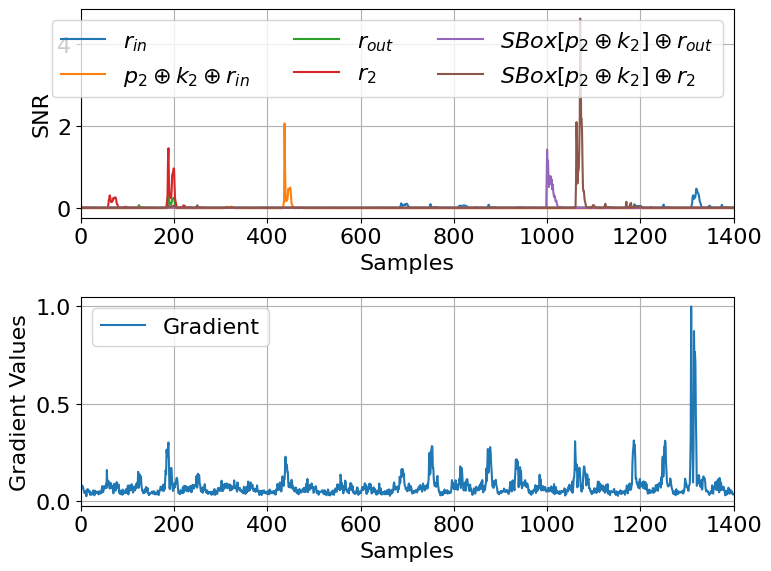

In [ ]:
# Finding leakage and input visualization
def gradient_vis(x, y):
  x_tf = tf.Variable(x)
  with tf.GradientTape() as tape:
    tape.watch(x_tf)
    pred = model(x_tf, training=False)
    loss = tf.keras.losses.CategoricalCrossentropy()(y, pred)

  grads = tape.gradient(loss, x_tf)
  dgrad_abs = tf.math.abs(grads)

  return np.median(dgrad_abs.numpy(), axis=0)

nb_traces_snr_comp = 20000

# Remove final dimension for CNN reshapes
if len(X_attack.shape) > 2:
  X_attack = X_attack[:, :, 0]

#Define intermediate variable shares using masking randomness
masks = attack_metadata["masks"][:, target_byte].astype(np.uint8)
masked_sbox = AES_Sbox[attack_metadata["plaintext"][:, target_byte].astype(np.uint8) ^ attack_metadata["key"][:, target_byte].astype(np.uint8)]^ masks


masks_out = attack_metadata["masks"][:, 17].astype(np.uint8)
masked_sbox_out = AES_Sbox[attack_metadata["plaintext"][:, target_byte].astype(np.uint8) ^ attack_metadata["key"][:, target_byte].astype(np.uint8)]^ masks_out


masks_in = attack_metadata["masks"][:, 16].astype(np.uint8)
masked_sbox_in =attack_metadata["plaintext"][:, target_byte].astype(np.uint8) ^ attack_metadata["key"][:, target_byte].astype(np.uint8)^ masks_in

#Compute Signal-to-Noise ratios for each intermediate value share
mask_snr_out = snr_fast(X_attack[:nb_traces_snr_comp], masks_out[:nb_traces_snr_comp])
masked_sbox_out_snr = snr_fast(X_attack[:nb_traces_snr_comp], masked_sbox_out[:nb_traces_snr_comp])
mask_snr = snr_fast(X_attack[:nb_traces_snr_comp], masks[:nb_traces_snr_comp])
masked_sbox_snr = snr_fast(X_attack[:nb_traces_snr_comp], masked_sbox[:nb_traces_snr_comp])
mask_snr_in = snr_fast(X_attack[:nb_traces_snr_comp], masks_in[:nb_traces_snr_comp])
masked_sbox_in_snr = snr_fast(X_attack[:nb_traces_snr_comp], masked_sbox_in[:nb_traces_snr_comp])

#Compute gradients visualizations for intermediag
if len(Y_attack.shape) == 1:
  grads = gradient_vis(X_attack[:nb_traces_snr_comp], to_categorical(Y_attack[:nb_traces_snr_comp], nb_classes))
else:
  grads = gradient_vis(X_attack[:nb_traces_snr_comp], Y_attack[:nb_traces_snr_comp])

#Plot gradients with SNRs
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(mask_snr_in, label="$r_{in}$")
plt.plot(masked_sbox_in_snr/5, label="$p_2 \oplus k_2 \oplus r_{in}$")
plt.plot(mask_snr_out, label="$r_{out}$")
plt.plot(mask_snr, label="$r_{2}$")
plt.plot(masked_sbox_out_snr, label="$SBox[p_2 \oplus k_2] \oplus r_{out}$")
plt.plot(masked_sbox_snr, label="$SBox[p_2 \oplus k_2] \oplus r_2$")
plt.legend(ncol=3, loc=0)
plt.grid()
plt.ylabel("SNR")
plt.xlim([0,1400])
plt.xlabel("Samples")
plt.subplot(2, 1, 2)
plt.plot(grads/np.max(grads), label="Gradient")
plt.legend(loc=0)
plt.ylabel("Gradient Values")
plt.grid()
plt.xlim([0,1400])
plt.xlabel("Samples")
plt.tight_layout()

plt.show()

## Hyperparameter search
Here, we include an example of how to perform a hyperparameter search. We utilize a random search here with ranges from Perin, G., Wu, L., & Picek, S. (2022). Exploring feature selection scenarios for deep learning-based side-channel analysis. IACR Transactions on Cryptographic Hardware and Embedded Systems, 2022(4), 828-861.

Note that we download the fixed key variant of ASCAD as it is smaller, which allows for faster individual model training. Also, since we use a different data set, only the *Imports and Setup* section has to be successfully executed before running code cells in this section.

In [ ]:
!wget https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
!unzip ASCAD_data.zip

--2025-01-06 09:28:05--  https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.91, 37.59.183.73
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4435199469 (4.1G) [application/zip]
Saving to: ‘ASCAD_data.zip’

ASCAD_data.zip      100%[===================>]   4.13G  20.3MB/s    in 3m 41s  

2025-01-06 09:31:48 (19.1 MB/s) - ‘ASCAD_data.zip’ saved [4435199469/4435199469]

Archive:  ASCAD_data.zip
   creating: ASCAD_data/
   creating: ASCAD_data/ASCAD_databases/
  inflating: ASCAD_data/ASCAD_databases/ASCAD.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync100.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync50.h5  
  inflating: ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5  
   creating: ASCAD_data/ASCAD_trained_models/
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync0_epochs75_classes

In [ ]:
# Load fixed dataset
ascad_dataset = '/content/ASCAD_data/ASCAD_databases/ASCAD.h5'
(X_profiling, Y_profiling), (X_attack, Y_attack), (profiling_metadata, attack_metadata) = load_ascad(ascad_dataset, load_metadata=True)
scaler = StandardScaler()
X_profiling = scaler.fit_transform(X_profiling)
X_attack = scaler.transform(X_attack)
leakage_model = 'ID'
if leakage_model == 'HW':
  nb_classes = 9
elif leakage_model == 'ID':
  nb_classes = 256
if leakage_model == 'HW':
  Y_profiling = calculate_HW(Y_profiling)
  Y_attack = calculate_HW(Y_attack)
Y_profiling= to_categorical(Y_profiling, num_classes=nb_classes)
Y_attack= to_categorical(Y_attack, num_classes=nb_classes)
target_byte=2

In [ ]:
# The ranges are taken from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
# Their implementation is available on GitHub https://github.com/AISyLab/feature_selection_dlsca/tree/master
# with more extensive ranges that additionally include regularization methods.
def get_hyperparameters_mlp(max_dense_layers=8):
  return {
      "batch_size": random.randrange(100, 1100, 100),
      "layers": random.randrange(1, max_dense_layers + 1, 1),
      "neurons": random.choice([10, 20, 50, 100, 200, 300, 400, 500]),
      "activation": random.choice(["relu", "selu"]),
      "learning_rate": random.choice([0.005, 0.001, 0.0005, 0.0001]),
      "optimizer": random.choice(["Adam", "RMSprop"]),
      "kernel_initializer": random.choice(["random_uniform", "glorot_uniform", "he_uniform"]),
      "regularization": random.choice(["none"])
  }

def get_hyperparemeters_cnn(max_conv_layers=4, max_dense_layers=4):
    hyperparameters = {}
    hyperparameters_mlp = get_hyperparameters_mlp(max_dense_layers)
    for key, value in hyperparameters_mlp.items():
        hyperparameters[key] = value

    conv_layers = random.choice(range(1, max_conv_layers))
    kernels = []
    strides = []
    filters = []
    pooling_types = []
    pooling_sizes = []
    pooling_strides = []
    pooling_type = random.choice(["Average", "Max"])

    for conv_layer in range(1, conv_layers + 1):
        kernel = random.randrange(26, 52, 2)
        kernels.append(kernel)
        strides.append(int(kernel / 2))
        if conv_layer == 1:
            filters.append(random.choice([4, 8, 12, 16]))
        else:
            filters.append(filters[conv_layer - 2] * 2)
        pool_size = random.choice([2, 4, 6, 8, 10])
        pooling_sizes.append(pool_size)
        pooling_strides.append(pool_size)
        pooling_types.append(pooling_type)

    hyperparameters["conv_layers"] = conv_layers
    hyperparameters["kernels"] = kernels
    hyperparameters["strides"] = strides
    hyperparameters["filters"] = filters
    hyperparameters["pooling_sizes"] = pooling_sizes
    hyperparameters["pooling_strides"] = pooling_strides
    hyperparameters["pooling_types"] = pooling_types
    return hyperparameters


def get_optimizer(optimizer, learning_rate):
    module_name = importlib.import_module("tensorflow.keras.optimizers")
    optimizer_class = getattr(module_name, optimizer)
    return optimizer_class(learning_rate=learning_rate)


# Function that uses the random hyperparameters or those given as an argument to create an MLP model.
def mlp_random(classes, input_size, hp=None):
    hp = get_hyperparameters_mlp() if hp is None else hp

    inputs = Input(shape=(input_size, ))

    x = None
    for layer_index in range(hp["layers"]):
        x = Dense(hp["neurons"], activation=hp["activation"], kernel_initializer=hp["kernel_initializer"],
                      name='dense_{}'.format(layer_index))(inputs if layer_index == 0 else x)

    outputs = Dense(classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='random_mlp')
    optimizer = get_optimizer(hp["optimizer"], hp["learning_rate"])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model, hp

# Function that uses the random hyperparameters or those given as an argument to create a CNN model.
def cnn_random(classes, input_size, hp=None):
  hp = get_hyperparemeters_cnn() if hp is None else hp

  inputs = Input(shape=(input_size, 1))

  x = None
  for layer_index in range(hp["conv_layers"]):
      x = Conv1D(kernel_size=hp["kernels"][layer_index], strides=hp["strides"][layer_index], filters=hp["filters"][layer_index],
                  activation=hp["activation"], padding="same")(inputs if layer_index == 0 else x)
      if hp["pooling_types"][layer_index] == "average":
          x = AveragePooling1D(pool_size=hp["pooling_sizes"][layer_index], strides=hp["pooling_strides"][layer_index], padding="same")(x)
      else:
          x = MaxPooling1D(pool_size=hp["pooling_sizes"][layer_index], strides=hp["pooling_strides"][layer_index], padding="same")(x)
      x = BatchNormalization()(x)
  x = Flatten()(x)

  for layer_index in range(hp["layers"]):
      x = Dense(hp["neurons"], activation=hp["activation"], kernel_initializer=hp["kernel_initializer"],
                    name='dense_{}'.format(layer_index))(x)

  outputs = Dense(classes, activation='softmax', name='predictions')(x)

  model = Model(inputs, outputs, name='random_cnn')
  optimizer = get_optimizer(hp["optimizer"], hp["learning_rate"])
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model, hp

In [ ]:
# setting random seed
seed = 2324411508998340269 #random.randrange(sys.maxsize)
random.seed(seed)
# print('seed random was', seed)
seed = 1434111232 #random.randrange(2**32 - 1)
np.random.seed(seed)
# print('seed np random was', seed)

# The number of epochs per model and number of models can be modified to allow for more models and more extended training for better results.
# Here, we limit these numbers for faster training time and search.
nb_epochs_per_model = 20
nb_prof_traces = 40000
nb_val_traces = 10000
nb_models = 10
avg_ge_list = []
hp_list = []
model_list = []
input_size = len(X_profiling[0])

# Evaluation is done on the attack set, but for hyperparameter tuning,
# we use a subset of profiling set (validation set) for selecting the best model from the random search
X_val = X_profiling[nb_prof_traces:nb_prof_traces+nb_val_traces]
validation_pt = profiling_metadata["plaintext"][nb_prof_traces:nb_prof_traces+nb_val_traces, target_byte]
correct_key_val = profiling_metadata["key"][nb_tr, target_byte]
for i in range(nb_models):
    model, hp = mlp_random(classes=nb_classes, input_size=input_size)
    model.fit(x=X_profiling[:nb_prof_traces], y=Y_profiling[:nb_prof_traces], batch_size=hp["batch_size"], verbose=0, epochs=nb_epochs_per_model, shuffle=True)
    predictions = model.predict(X_val)
    ge_median, ge_avg = guessing_entropy(predictions, validation_pt, correct_key_val, 200)
    avg_ge_list.append(ge_avg)
    model_list.append(model.get_weights())
    print(f"Model {i} has GE {ge_avg}")
    hp_list.append(hp)

seed random was 2324411508998340269
seed np random was 1434111232
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 0 has GE 124.75
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 1 has GE 7.78
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 2 has GE 3.87
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model 3 has GE 0.89
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 4 has GE 9.3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 5 has GE 12.16
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 6 has GE 4.73
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 7 has GE 133.4
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 8 has GE 100.13
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 9 has GE 5.33


In [ ]:
index_best_hp = np.argmin(avg_ge_list)
best_hp = hp_list[index_best_hp]
print(f"Best GE is {avg_ge_list[index_best_hp]} with the hyperparameters {best_hp}.")
# We train the best hp again with more epochs.
nb_epochs = 50
batch_size = hp["batch_size"]
model, hp = mlp_random(classes=nb_classes, input_size=input_size, hp=best_hp)
history = model.fit(x=X_profiling, y=Y_profiling, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

Best GE is 0.89 with the hyperparameters {'batch_size': 900, 'layers': 5, 'neurons': 200, 'activation': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'kernel_initializer': 'random_uniform', 'regularization': 'none'}.
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0043 - loss: 5.5452
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0045 - loss: 5.5441
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0043 - loss: 5.5426
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0049 - loss: 5.5412
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0051 - loss: 5.5396
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0051 - loss: 5.5328
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0059 - loss: 5.5115
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0068 - loss: 5.4903
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0081 - loss: 5.4771
Epoch 10/50
84/84 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
GE of 0.0 with 478 traces.


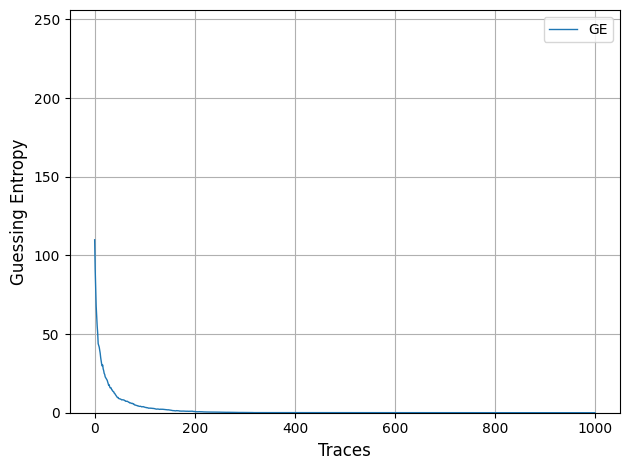

In [ ]:
# Evaluation of the best model found with random search hyperparameter tuning.
predictions = model.predict(X_attack)
correct_key = attack_metadata["key"][0, target_byte]
medge, avgge = guessing_entropy_convergence(predictions, attack_metadata["plaintext"][:, target_byte], correct_key, 1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
figure = plt.gcf()
plt.plot(avgge, linewidth=1, label="GE")
plt.grid(True, which="both", ls="-")
plt.xlabel("Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

## Ensemble
Here, we implement the basic ensembling technique from:
Perin, G., Chmielewski, Ł., & Picek, S. (2020). Strength in numbers: Improving generalization with ensembles in machine learning-based profiled side-channel analysis. IACR Transactions on Cryptographic Hardware and Embedded Systems, 337-364.

This part of the code relies on the previous section on hyperparameter tuning. Thus, the tuning has to be executed before running ensembles, as it will use the models trained during the tuning process.

0.89
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
3.87
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
4.73
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
5.33
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
7.78
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
GE of 0.0 with 604 traces.


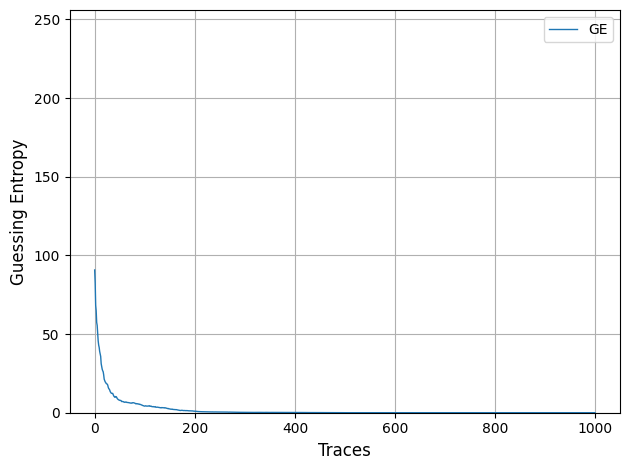

In [ ]:
# The number of models to use for the ensemble
nb_models_ensemble = 5

# Sort model indices based on GE
sorted_model_indices = np.argsort(avg_ge_list)

# Take predictions from top N models
predictions_tot = np.zeros((X_attack.shape[0], nb_classes))

for i in range(nb_models_ensemble):
  model_num = sorted_model_indices[i]
  print(avg_ge_list[model_num])
  # Recreate model based on hyperparameters
  hp = hp_list[model_num]
  model, _ = mlp_random(classes=nb_classes, input_size=input_size, hp=hp)

  # Restore trained weights
  model.set_weights(model_list[model_num])

  # Add to total predictions
  predictions_tot += model.predict(X_attack)


predictions_tot /= nb_models_ensemble
corect_key = attack_metadata["key"][0, target_byte]
medge, avgge = guessing_entropy_convergence(predictions_tot, attack_metadata["plaintext"][:, target_byte], correct_key, 1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
figure = plt.gcf()
plt.plot(avgge, linewidth=1, label="GE")
plt.grid(True, which="both", ls="-")
plt.xlabel("Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

## Feature Selection and Resampling
In this section, we show how to implement the NOPOI and RPOI scenarios from:
Perin, Guilherme, Lichao Wu, and Stjepan Picek. "Exploring feature selection scenarios for deep learning-based side-channel analysis." IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.

Please note that the setup here takes a relatively large amount of memory; we recommend restarting the kernel and only running the cells below to minimize memory overhead. Run only the *Imports and Setup* section before this section.

In [ ]:
# Download/unzip fixed key variant if it is not downloaded/unzipped already
if os.path.exists("/content/ASCAD_data.zip") == False:
  !wget https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
  !unzip ASCAD_data.zip
elif os.path.exists("/content/ASCAD_data/ASCAD_databases/ASCAD.h5") == False:
  !unzip ASCAD_data.zip

--2025-03-03 13:29:08--  https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.91, 37.59.183.73
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4435199469 (4.1G) [application/zip]
Saving to: ‘ASCAD_data.zip’

ASCAD_data.zip      100%[===================>]   4.13G  13.5MB/s    in 17m 6s  

2025-03-03 13:46:16 (4.12 MB/s) - ‘ASCAD_data.zip’ saved [4435199469/4435199469]

Archive:  ASCAD_data.zip
   creating: ASCAD_data/
   creating: ASCAD_data/ASCAD_databases/
  inflating: ASCAD_data/ASCAD_databases/ASCAD.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync100.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync50.h5  
  inflating: ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5  
   creating: ASCAD_data/ASCAD_trained_models/
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync0_epochs75_classes

###Raw trace  resampling (NOPOI)
Here, we implement the resampling for the NOPOI scenario. The resampling here uses a moving average filter over each trace and takes a step to take only every n'th value.

In [ ]:
import numpy as np
from tqdm import tqdm

# Original resampling function
def winres(trace, window=20, overlap=0.5):
    trace_winres = []
    step = int(window * overlap)
    max = len(trace)
    for i in range(0, max, step):
        # Take average over n=window sample points
        trace_winres.append(np.mean(trace[i:i + window]))
    return np.array(trace_winres)

# Optimized version to resample using a moving window
def winres_convolve(trace, window=20, overlap=0.5):
    step = int(window * overlap)
    kernel = np.ones(window) / window  # Create a moving average kernel
    convolved = np.convolve(trace, kernel, mode='same')  # Apply the kernel
    # Downsample the convolved result to match the step size
    trace_winres = convolved[::step]
    return trace_winres

# Loading from raw trace file is slightly different from earlier as data is not yet split into profiling and attack
def load_ascad_raw(ascad_database_file, load_metadata=False, target_byte=2):
  check_file_exists(ascad_database_file)
  # Open the ASCAD database HDF5 for reading
  try:
    in_file	 = h5py.File(ascad_database_file, "r")
  except:
    print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
    sys.exit(-1)

  # We resample here in batches to ensure the execution does not use too much memory
  # If more memory is available (i.e. not a free colab account)
  # raw traces can be loaded here and resampling can be done outside
  window = 20
  overlap = 0.5
  new_trace_len = int(100000 /(window*overlap))
  resampled_traces = np.zeros((50000, new_trace_len))
  resampled_attack = np.zeros((10000, new_trace_len))
  for i in range(10):
    raw_traces = np.array(in_file['traces'][i*5000:(i+1)*5000], dtype=np.int8)
    for j in tqdm(range(raw_traces.shape[0])):
      resampled_traces[(i*5000) + j] = winres_convolve(raw_traces[j], window=window, overlap=overlap)
  for i in range(10, 12):
    raw_traces = np.array(in_file['traces'][i*5000:(i+1)*5000], dtype=np.int8)
    for j in tqdm(range(raw_traces.shape[0])):
      resampled_attack[(i-10) * 5000 + j] = winres_convolve(raw_traces[j], window=window, overlap=overlap)

  gc.collect()
  raw_data = in_file['metadata']
  raw_plaintexts = raw_data['plaintext']
  raw_keys = raw_data['key']
  raw_masks = raw_data['masks']
  raw_labels = AES_Sbox[raw_plaintexts[:, target_byte].astype(np.uint8) ^ raw_keys[:, target_byte].astype(np.uint8)]

  # Load profiling labels
  Y_profiling = np.array(raw_labels[:50000])
  # Load attacking labels
  Y_attack = np.array(raw_labels[50000:])
  if load_metadata == False:
    return (resampled_traces, Y_profiling), (resampled_attack, Y_attack)
  else:
    return (resampled_traces, Y_profiling), (resampled_attack, Y_attack), (in_file['metadata'][:50000], in_file['metadata'][50000:])

In [ ]:
# Load raw traces dataset and do initialize neccesary variables
ascad_raw = '/content/ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5'
target_byte=2
leakage_model ="ID"
(X_profiling, Y_profiling), (X_attack, Y_attack), (profiling_metadata, attack_metadata) = load_ascad_raw(ascad_raw, load_metadata=True)

scaler = StandardScaler()
scaler.fit(X_profiling[:40000])
X_profiling = scaler.transform(X_profiling)
X_attack = scaler.transform(X_attack)


100%|██████████| 5000/5000 [00:08<00:00, 592.32it/s]


In [ ]:
from tensorflow.keras.regularizers import *
# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
def best_mlp_id_nopoi_10000_ascadf(classes, number_of_samples):
    # Best multilayer perceptron for ASCAD fixed key dataset
    # Number of points-of-interest: 10000
    # Leakage model: ID
    # POI interval: [0, 100000]
    # Number of parameters: 5379256

    batch_size = 100
    tf.random.set_seed(24638)
    model = Sequential(name='best_mlp_id_nopoi_ascadv_10000')
    model.add(Dense(500, activation='selu', kernel_regularizer=l2(0.0005), kernel_initializer="random_uniform", input_shape=(number_of_samples,)))
    model.add(Dense(500, activation='selu', kernel_regularizer=l2(0.0005), kernel_initializer="random_uniform"))
    model.add(Dense(classes, activation='softmax'))
    optimizer = RMSprop(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model, batch_size

In [ ]:
# Manual call to garbace collector to minimize unnecessary memory to prevent crash
gc.collect()
leakage_model = "ID"
if leakage_model == 'HW':
  nb_classes = 9
elif leakage_model == 'ID':
  nb_classes = 256

if leakage_model == 'HW':
  Y_profiling = calculate_HW(Y_profiling)
  Y_attack = calculate_HW(Y_attack)

# Since we use classification, we turn the the label values into categorical
Y_profiling = to_categorical(Y_profiling, num_classes=nb_classes)
Y_attack = to_categorical(Y_attack, num_classes=nb_classes)
# Training
input_size= len(X_profiling[0])
model, batch_size = best_mlp_id_nopoi_10000_ascadf(nb_classes, input_size)
nb_epochs = 100
history = model.fit(x=X_profiling, y=Y_profiling, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0039 - loss: 9.2611
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0078 - loss: 6.6933
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0279 - loss: 6.1794
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0569 - loss: 5.9217
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0870 - loss: 5.7559
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1166 - loss: 5.6231
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1456 - loss: 5.4974
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1709 - loss: 5.3924
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1950 - loss: 5.2828
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2190 - loss: 5.1813
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2424 - loss: 5.0825
Epoch 12/100
500/500 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
GE of 0.0 with 11 traces.


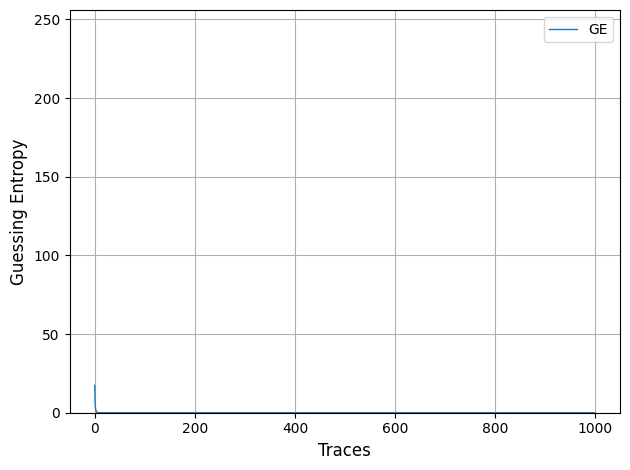

In [ ]:
# Evaluation of the model in NOPOI scenario.
predictions = model.predict(X_attack)
correct_key = attack_metadata["key"][0, target_byte]
medge, avgge = guessing_entropy_convergence(predictions, attack_metadata["plaintext"][:, target_byte], correct_key, 1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
figure = plt.gcf()
plt.plot(avgge, linewidth=1, label="GE")
plt.grid(True, which="both", ls="-")
plt.xlabel("Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()

### Window Selection (OPOI)

Here we do feature selection based on some window presumed to contain the sensitive operations. Note that we include this here for completeness, but the attacks in previous sections are already in the OPOI setting so we do not repeat the attacks.



In [ ]:
def load_ascad_window(ascad_database_file, load_metadata=False, target_byte=2, start_index=45400, end_index=46100):
  check_file_exists(ascad_database_file)
  # Open the ASCAD database HDF5 for reading
  try:
    in_file	 = h5py.File(ascad_database_file, "r")
  except:
    print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
    sys.exit(-1)
  window_traces = in_file['traces'][:50000][start_index:end_index]
  window_attack = in_file['traces'][50000:][start_index:end_index]
  raw_data = in_file['metadata']
  raw_plaintexts = raw_data['plaintext']
  raw_keys = raw_data['key']
  raw_masks = raw_data['masks']
  raw_labels = AES_Sbox[raw_plaintexts[:, target_byte].astype(np.uint8) ^ raw_keys[:, target_byte].astype(np.uint8)]

  # Load profiling labels
  Y_profiling = np.array(raw_labels[:50000])
  # Load attacking labels
  Y_attack = np.array(raw_labels[50000:])
  if load_metadata == False:
    return (window_traces, Y_profiling), (window_attack, Y_attack)
  else:
    return (window_traces, Y_profiling), (window_attack, Y_attack), (in_file['metadata'][:50000], in_file['metadata'][50000:])
ascad_raw = '/content/ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5'
load_ascad_window(ascad_raw, load_metadata=True, target_byte=2, start_index=45400, end_index=46100)

((array([[ 54,  49,  42, ..., -20,  -2,  16],
         [ 53,  46,  41, ..., -12,   7,  22],
         [ 55,  50,  44, ..., -21,  -2,  17],
         ...,
         [ 52,  45,  40, ..., -13,   5,  20],
         [ 54,  48,  41, ..., -17,   1,  19],
         [ 57,  53,  46, ..., -25,  -6,  13]], dtype=int8),
  array([ 38,  47,  38, ..., 131,  64,  52])),
 (array([], shape=(0, 100000), dtype=int8),
  array([214,  34,  47, ..., 101, 171, 236])),
 (array([([  6,  65, 195,  66,  25, 182, 248,  19, 159, 132,  97,   6,  46, 137,  42,  16], [ 95,  75, 255, 146, 229,  35,  24,  50,  16, 107, 238,  33,  93,  56, 106, 178], [ 77, 251, 224, 242, 114,  33, 254,  16, 167, 141,  74, 220, 142,  73,   4, 105], [  7,  84,  71, 171, 129, 171,  90, 193, 236, 131,  21, 112, 185,  95, 212,  55]),
         ([ 64,  84, 174, 122,  92, 107, 179,   4, 192,  55,  90, 128, 132,  74, 139,  27], [ 23, 248, 254,  14,  91, 201,   8, 132,  57, 212, 123,  91,  91, 233, 227,  72], [ 77, 251, 224, 242, 114,  33, 254,  16, 167,

### Feature Selection (RPOI)
Here we do feature selection based on known masks. Note that we select features from resampled traces, this is to limit RAM usage, for optimal results we would select features from the raw traces without resampling.

In [3]:
def snr_fast(x, y):
    ns = x.shape[1]
    unique = np.unique(y)
    means = np.zeros((len(unique), ns))
    variances = np.zeros((len(unique), ns))

    for i, u in enumerate(unique):
        new_x = x[np.argwhere(y == int(u))]
        means[i] = np.mean(new_x, axis=0)
        variances[i] = np.var(new_x, axis=0)
    return np.var(means, axis=0) / np.mean(variances, axis=0)

def get_poi_share(x, y, n_poi=50):
  snrs = snr_fast(x[:20000], y[:20000])

  # plt.figure(figsize=(14,5))
  # plt.plot(snrs)
  # plt.title("SNR trace for HW leakage model")
  # plt.xlabel('Time sample')
  # plt.ylabel('SNR value')
  # plt.show()
  
  print(f"SNR: {len(snrs)}")
  return np.argsort(snrs)[::-1][:n_poi]

# We do -2 here as first two bytes have no masks included for fixed key dataset,
# For variable key this should be excluded
masks = profiling_metadata["masks"][:, target_byte-2].astype(np.uint8)
masked_sbox_out = AES_Sbox[profiling_metadata["plaintext"][:, target_byte].astype(np.uint8) ^ profiling_metadata["key"][:, target_byte].astype(np.uint8)]^ masks

print(X_profiling.shape)
print(masked_sbox_out.shape)


poi_sbox_out_masked = get_poi_share(X_profiling, masked_sbox_out)
poi_masks = get_poi_share(X_profiling, masks)
poi_full = np.append(poi_sbox_out_masked, poi_masks)

selected_features = X_profiling[:, poi_full]
selected_features_attack = X_attack[:, poi_full]
print(f"Shape of selected features:{selected_features.shape}") # there are 100 pints selected per all 200000000 traces



NameError: name 'profiling_metadata' is not defined

In [2]:
# Model taked from Perin, Guilherme, Lichao Wu, and Stjepan Picek.
# "Exploring feature selection scenarios for deep learning-based side-channel analysis."
# IACR Transactions on Cryptographic Hardware and Embedded Systems 2022.4 (2022): 828-861.
def best_mlp_id_rpoi_100_ascadf(classes, number_of_samples):
    # Best multilayer perceptron for ASCADf dataset
    # Number of points-of-interest: 100
    # Leakage model: ID
    # Number of parameters: 429256

    batch_size = 100
    tf.random.set_seed(917539)
    model = Sequential(name="best_mlp_id_rpoi_100_ascadf")
    model.add(Dense(500, activation="relu", kernel_initializer="he_uniform", input_shape=(number_of_samples,)))
    model.add(Dense(500, activation="relu", kernel_initializer="he_uniform"))
    model.add(Dense(classes, activation="softmax"))
    model.summary()
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, batch_size

In [1]:
print(selected_features)

NameError: name 'selected_features' is not defined

In [ ]:
# Training
input_size= len(selected_features[0])
model, batch_size = best_mlp_id_rpoi_100_ascadf(nb_classes, input_size)
nb_epochs = 100
history = model.fit(x=selected_features, y=Y_profiling, shuffle=True, batch_size=batch_size, verbose=1, epochs=nb_epochs)

Model: "best_mlp_id_rpoi_100_ascadf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 500)                 │          50,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         128,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 429,256 (1.64 MB)

 Trainable params: 429,256 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0042 - loss: 5.7918
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0111 - loss: 5.4843
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0161 - loss: 5.3094
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0232 - loss: 5.0700
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0343 - loss: 4.8500
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0460 - loss: 4.6646
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0566 - loss: 4.4967
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0705 - loss: 4.3376
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0854 - loss: 4.1843
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1028 - loss: 4.0360
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1201 - loss: 3.8912
Epoch 12/100
500/500 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
GE of 0.0 with 3 traces.


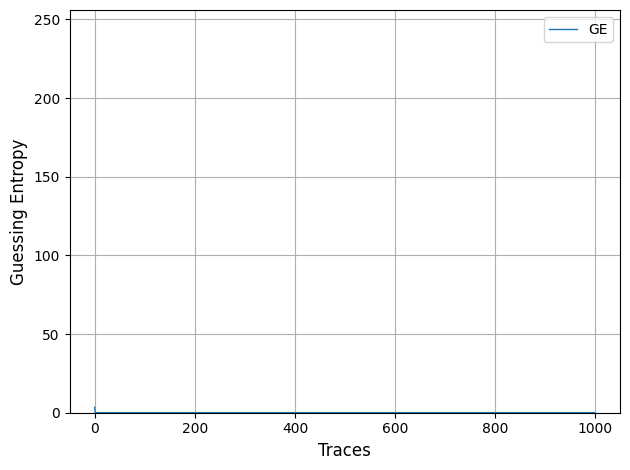

In [ ]:
# Evaluation of the model in NOPOI scenario.
predictions = model.predict(selected_features_attack)
correct_key = attack_metadata["key"][0, target_byte]
medge, avgge = guessing_entropy_convergence(predictions, attack_metadata["plaintext"][:, target_byte], correct_key, 1000)
print(f"GE of {np.min(avgge)} with {np.argmin(avgge)} traces.")
figure = plt.gcf()
plt.plot(avgge, linewidth=1, label="GE")
plt.grid(True, which="both", ls="-")
plt.xlabel("Traces", fontsize=12)
plt.ylabel("Guessing Entropy", fontsize=12)
plt.ylim(0, 256)
plt.legend()
plt.tight_layout()